In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize

data = pd.read_excel('/Users/matiasgonzalez/Desktop/Backtesting/bbdd seleccion portafolio.xlsx', index_col=0, parse_dates=True)
data = data.sort_index(ascending=True)
nombres = {'SPX Index': 'USA', 'MXEUG Index': 'Europa equities', 'UKX Index': 'UK', 'MXJP Index': 'Japon', 'MXAPJ Index': 'Asia',
            'MXLA Index': 'Latam', 'LF98TRUU Index': 'US HY', 'LUACTRUU Index': 'US IG', 'LBEATRUH Index': 'Europa bonds', 'BSELTRUU Index': 'Latam corp',
              'BSSUTRUU Index': 'Emerging sov', 'CABS Index': 'ABS', 'BCOMTR Index': 'Commodities', 'GLD US EQUITY': 'Oro', 'MXWD Index': 'World equities',}
data = data.rename(columns=nombres)
data

,USA,Europa equities,UK,Japon,Asia,Latam,US HY,US IG,Europa bonds,Latam corp,Emerging sov,ABS,Commodities,Oro,World equities
Dates,,,,,,,,,,,,,,,
2009-12-20,1104.0608,134.7947,8376.2673,6.1667,397.9240,3976.9720,1044.25,1905.70,189.55,555.2780,210.5655,150.639,271.8540,108.95,292.7944
2009-12-21,1115.6747,136.6045,8517.0090,6.1270,395.1220,3964.6336,1044.88,1893.96,189.14,554.5421,210.4116,150.407,270.7502,106.95,295.2558
2009-12-22,1119.6683,137.3385,8523.7259,6.1664,398.5079,4004.6886,1046.41,1889.69,188.91,555.3576,210.5412,150.258,270.5780,106.17,296.3599
2009-12-23,1122.4861,138.4527,8588.8493,6.1866,402.9362,4043.5493,1047.55,1891.02,188.62,555.1265,210.4938,150.368,275.4902,106.55,298.3813
2009-12-24,1128.3889,138.4434,8624.4220,6.2528,407.3329,4069.3275,1047.69,1883.73,188.63,554.6907,210.4230,150.244,276.9486,108.36,300.0590
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-27,8279.5665,410.8031,21521.1220,17.0339,1018.2141,4289.9620,2798.56,3410.50,311.33,1194.8937,426.3266,250.598,253.8582,301.22,1329.5316
2025-06-28,8279.5665,410.8031,21521.1220,17.0339,1018.2141,4289.9620,2798.56,3410.50,311.33,1194.8937,426.3266,250.598,253.8582,301.22,1329.5316
2025-06-29,8279.5665,410.8031,21521.1220,17.0339,1018.2141,4289.9620,2798.56,3410.50,311.33,1194.8937,426.3266,250.598,253.8582,301.22,1329.5316


In [3]:
# Compute daily returns and drop rows with missing values
returns = data.pct_change().dropna(how="all")
#Eliminar valores cero
#returns = returns[~(returns == 0).any(axis=1)]
returns_modelos = returns.iloc[:, 0:14]  # Select first 14 columns for modeling
returns_modelos 
returns_modelos.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/returns_modelos.xlsx')

# Portafolio BVC 


In [62]:
#Benchmark Portfolio Backtest conservador 
def backtest_portafolio_bvc(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    weights = None
    historical_weights = []

    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            weights = [0.251, 0.054, 0.011, 0.026, 0.03, 0.009, 0.023, 0.224, 0.037, 0.281, 0, 0.016, 0.01, 0.025] 
            if np.sum(weights) != 1:
                weights = weights / np.sum(weights)
            period_return = np.sum(weights * current_daily_returns)
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if np.sum(weights) != 1:
                weights = weights / np.sum(weights)
            period_return = np.sum(weights * current_daily_returns)

        portfolio_returns.append(period_return)
        historical_weights.append(weights)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portafolio_bvc_results, weights_portafolio_bvc = backtest_portafolio_bvc(returns_modelos)
weights_portafolio_bvc.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_portafolio_bvc.xlsx', index=True)
#print(benchmark_conservador_results)
retorno_acum_portafolio_bvc = (1+portafolio_bvc_results).cumprod()
print(retorno_acum_portafolio_bvc)


Dates
2014-12-20    1.000000
2014-12-21    1.000000
2014-12-22    1.003955
2014-12-23    1.002947
2014-12-24    1.003258
                ...   
2025-06-27    2.176643
2025-06-28    2.176643
2025-06-29    2.176643
2025-06-30    2.184802
2025-07-01    2.186621
Length: 3847, dtype: float64


# Benchmarks 

In [63]:
#Benchmark Portfolio Backtest conservador 
def backtest_benchmark_conservador(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    weights = None
    historical_weights = []
    activos = ['World equities', 'US IG', 'Oro']
    returns = returns[activos]
    n_assets = len(activos)

    rebalance_dates = returns.resample(rebalance_freq).last().index
    
    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            weights = [.35, .6, .05] 
            if np.sum(weights) != 1:
                weights = weights / np.sum(weights)
            period_return = np.sum(weights * current_daily_returns)
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if np.sum(weights) != 1:
                weights = weights / np.sum(weights)
            period_return = np.sum(weights * current_daily_returns)

        portfolio_returns.append(period_return)
        historical_weights.append(weights)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

benchmark_conservador_results, weights_benchmark_conservador = backtest_benchmark_conservador(returns)
weights_benchmark_conservador.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_benchmark_conservador.xlsx', index=True)
#print(benchmark_conservador_results)
retorno_acum_benchmark_conservador = (1+benchmark_conservador_results).cumprod()
print(retorno_acum_benchmark_conservador)


Dates
2014-12-20    1.000000
2014-12-21    1.000000
2014-12-22    1.001832
2014-12-23    0.998309
2014-12-24    0.999246
                ...   
2025-06-27    1.935365
2025-06-28    1.935365
2025-06-29    1.935365
2025-06-30    1.944444
2025-07-01    1.945672
Length: 3847, dtype: float64


In [64]:
#Benchmark Portfolio Backtest agresivo 
def backtest_benchmark_agresivo(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    weights = None
    historical_weights = []
    activos = ['World equities', 'US IG', 'Oro']
    returns = returns[activos]
    n_assets = len(activos)

    rebalance_dates = returns.resample(rebalance_freq).last().index
    
    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            weights = [.6, .35, .05] 
            if np.sum(weights) != 1:
                weights = weights / np.sum(weights)
            period_return = np.sum(weights * current_daily_returns)
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if np.sum(weights) != 1:
                weights = weights / np.sum(weights)
            period_return = np.sum(weights * current_daily_returns)

        portfolio_returns.append(period_return)
        historical_weights.append(weights)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

benchmark_agresivo_results, weights_benchmark_agresivo = backtest_benchmark_agresivo(returns)
weights_benchmark_agresivo.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_benchmark_agresivo.xlsx', index=True)
#print(benchmark_conservador_results)
retorno_acum_agresivo = (1+benchmark_agresivo_results).cumprod()
print(retorno_acum_agresivo)


Dates
2014-12-20    1.000000
2014-12-21    1.000000
2014-12-22    1.002564
2014-12-23    1.000502
2014-12-24    1.001470
                ...   
2025-06-27    2.344459
2025-06-28    2.344459
2025-06-29    2.344459
2025-06-30    2.354725
2025-07-01    2.355595
Length: 3847, dtype: float64


# Restricciones 

In [65]:
#Restricciones de la cartera
def get_portfolio_asset_constraints():
        cons = [
                {'type': 'ineq', 'fun': lambda w: w[0:6].sum() - 0.25},  # At least 25% in equities
                {'type': 'ineq', 'fun': lambda w: w[6:12].sum() - 0.25},  # At least 25% in bonds
                {'type': 'ineq', 'fun': lambda w: w[12:14].sum() - 0.00},  # No lower limit for commodities
                {'type': 'ineq', 'fun': lambda w: 0.70 - w[0:6].sum()},  # Max 70% in equities
                {'type': 'ineq', 'fun': lambda w: 0.70 - w[6:12].sum()},  # Max 70% in bonds
                {'type': 'ineq', 'fun': lambda w: 0.15 - w[12:14].sum()}   # Max 15% in commodities
        ]
        return cons

def get_asset_maximums(returns_modelos):
    cons = []
    max_weight = 0.15
    for i in range(len(returns_modelos.columns)):
        cons.append({
            'type': 'ineq',
            'fun': lambda w, i=i: max_weight - w[i]
        })

    return cons

In [66]:
# CVaR, VaR y retorno anualizado
def cvar_loss(w, S, alpha=0.05):
    """Calcula el Conditional Value at Risk (CVaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha)
    if var < 0:
        var = var
    else:
        var = 0
    cvar = (var - (1 / (alpha * len(portf_rets))) * np.sum(np.maximum(var - portf_rets, 0))) * np.sqrt(365)
    return -cvar

def var_loss(w, S, alpha=0.05):
    """Calcula el Value at Risk (VaR)"""
    portf_rets = S @ w
    var = np.percentile(portf_rets, 100 * alpha) * np.sqrt(365)
    if var < 0:
        var = -var
    else:
        var = 0
    return var

def calcular_retorno_anualizado(returns, days=365):
    retorno_acumulado = (1+returns).prod()
    num_años = len(returns) / days
    retorno_anualizado = (retorno_acumulado ** (1/num_años)) - 1
    return retorno_anualizado

def port_vol(w,cov):
    return np.sqrt(np.dot(w.T, np.dot(cov, w))) * np.sqrt(365)  # Annualized volatility

# Risk parity

In [67]:
# Calculate the covariance matrix
def port_var(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

#Calculate the risk contribution of each asset
def calculate_risk_contribution(weights, cov_matrix):
    portfolio_variance = port_var(weights, cov_matrix)
    marginal_contrib = np.dot(cov_matrix, weights)
    risk_contrib = np.multiply(weights, marginal_contrib) / portfolio_variance
    return risk_contrib

#Crear la función objetivo que disminuye la contribución de riesgo
def risk_parity_objective(weights, cov_matrix):
    risk_contrib = calculate_risk_contribution(weights, cov_matrix)
    target_risk = np.mean(risk_contrib)
    return np.sum((risk_contrib - target_risk) ** 2)



In [68]:
def calculate_risk_parity_weights(returns):
    cov_matrix = returns.cov().values  # Convert to NumPy array
    n_assets = returns.shape[1]
    initial_weights = np.array([1/n_assets] * n_assets)
    constraints = [
        {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},  # weights sum to 1
        {'type': 'ineq', 'fun': lambda x: x}              # non-negative weights
    ]
    result = minimize(risk_parity_objective, 
                      initial_weights,
                      args=(cov_matrix,),
                      method='SLSQP',
                      constraints=constraints,
                      options={'ftol': 1e-12})
    return result.x

In [69]:
# Backtesting the strategy
def backtest_risk_parity(returns, lookback=(365*5), rebalance_freq='QE'):
    historical_weights = []
    portfolio_returns = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_risk_parity_weights(historical)
            if weights.sum() != 1:
                weights = weights / weights.sum()
        else: 
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if weights.sum != 1:
                weights = weights / weights.sum()


        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns)


portfolio_rp_results, weights_rp = backtest_risk_parity(returns_modelos)
#print(weights_rp)
#print(portfolio_rp_results)
retorno_acum_rp = (1+portfolio_rp_results).cumprod()
print(retorno_acum_rp)
weights_rp.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_rp.xlsx', index=True)

Dates
2014-12-20    1.000000
2014-12-21    1.000000
2014-12-22    1.001419
2014-12-23    1.000647
2014-12-24    1.000674
                ...   
2025-06-27    1.680751
2025-06-28    1.680751
2025-06-29    1.680751
2025-06-30    1.684376
2025-07-01    1.686460
Length: 3847, dtype: float64


# Equal weight

In [70]:
from datetime import timedelta
#Equal weight strategy
def backtest_equal_weigth(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    weights = None
    n_assets = returns.shape[1]
    historical_weights = []

    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            weights = np.array([1/n_assets] * n_assets)
            if weights.sum != 1:
                weights = weights / weights.sum() # Normalize weights to sum to 1
            period_return = np.sum(weights * current_daily_returns)
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if weights.sum != 1:
                weights = weights / weights.sum()
            period_return = np.sum(weights * current_daily_returns)

        #print(f"Date: {date}, Weights: {weights}, Period Return: {period_return}")
        portfolio_returns.append(period_return)
        historical_weights.append(weights)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_ew_results, weights_ew = backtest_equal_weigth(returns_modelos)
#print(portfolio_ew_results)
#weights_ew.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_ew.xlsx', index=True)
retorno_acum_ew = (1+portfolio_ew_results).cumprod()
retorno_acum_ew



Dates
2014-12-20    1.000000
2014-12-21    1.000000
2014-12-22    1.001478
2014-12-23    1.001105
2014-12-24    1.000922
                ...   
2025-06-27    2.115790
2025-06-28    2.115790
2025-06-29    2.115790
2025-06-30    2.121190
2025-07-01    2.125033
Length: 3847, dtype: float64

# MVO

In [71]:
def neg_sharpe_penalizado(w, mu, cov, S, lambda_cvar=0.05, alpha=0.05):
    port_return = np.dot(w, mu)
    port_vol = np.sqrt(np.dot(w, np.dot(cov, w))) * np.sqrt(365)  # Annualized volatility
    #print(f"Port Return: {port_return}, Port Volatility: {port_vol}, Weights: {w}")
    sharpe = port_return / port_vol if port_vol > 0 else 0
    #print(f"Sharpe Ratio: {sharpe}, Weights: {w}")
    sharpe = 0.00001 if sharpe < 0 else sharpe  # Evitar sharpe negativo
    cvar = cvar_loss(w, S, alpha)
    cvar = cvar if sharpe > cvar else 0
    #print(f"CVaR: {cvar}, Sharpe: {sharpe}")
    return -(sharpe - lambda_cvar * cvar)

def calculate_mvo_weights_lim_cvar_max15(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    cov = returns.cov().values
    S = returns.values
    lambda_cvar = 0.2  # Penalty factor for CVaR
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
    ]
            
    cons_assets = get_portfolio_asset_constraints()
    cons.extend(cons_assets)
    
    # Restricción para que ningún activo tenga más de un 20% de la cartera
    cons_assets_max = get_asset_maximums(returns)
    cons.extend(cons_assets_max)

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n
    #print(f"Initial Weights: {w0}")

    res = minimize(
        neg_sharpe_penalizado, w0, args=(mu, cov, S, lambda_cvar, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [72]:
def backtest_mvo_lim_cvar_max15(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_mvo_weights_lim_cvar_max15(historical)
            if weights.sum != 1:
                weights = weights / weights.sum()
        else: 
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if weights.sum != 1:
                weights = weights / weights.sum() 

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_mvo_results_lim_cvar_max15, weights_mvo_lim_cvar_max15 = backtest_mvo_lim_cvar_max15(returns_modelos)
print(weights_mvo_lim_cvar_max15)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_mvo_lim_cvar_max15 = (1+portfolio_mvo_results_lim_cvar_max15).cumprod()
print(retorno_acum_mvo_lim_cvar_max15)
retorno_acum_mvo_lim_cvar_max15.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/retornos_acum_mvo_lim_cvar_max15.xlsx')
weights_mvo_lim_cvar_max15.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_mvo_lim_cvar_max15.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:4: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:4: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:4: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


                 USA  Europa equities        UK     Japon      Asia  \
Dates                                                                 
2014-12-20  0.150000     0.000000e+00  0.000000  0.068258  0.031742   
2014-12-21  0.150000     0.000000e+00  0.000000  0.068258  0.031742   
2014-12-22  0.150379     0.000000e+00  0.000000  0.068113  0.032107   
2014-12-23  0.150745     0.000000e+00  0.000000  0.068157  0.031874   
2014-12-24  0.150634     0.000000e+00  0.000000  0.068428  0.031903   
...              ...              ...       ...       ...       ...   
2025-06-27  0.158682     5.337196e-15  0.035909  0.044579  0.026154   
2025-06-28  0.158682     5.337196e-15  0.035909  0.044579  0.026154   
2025-06-29  0.158682     5.337196e-15  0.035909  0.044579  0.026154   
2025-06-30  0.150000     1.090945e-15  0.092230  0.049299  0.001455   
2025-07-01  0.149641     1.086492e-15  0.092441  0.048970  0.001460   

                   Latam     US HY         US IG  Europa bonds  Latam corp  

# Max Return 

In [73]:
def max_return(w, mu):
    port_return = np.dot(w, mu)
    return -port_return

def calculate_maxreturn_weight(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    S = returns.values
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    # Definir las restricciones
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x}  # non-negative weights
    ]
            
    cons_assets = get_portfolio_asset_constraints()
    cons.extend(cons_assets)
    
    # Restricción para que ningún activo tenga más de un 20% de la cartera
    cons_assets_max = get_asset_maximums(returns)
    cons.extend(cons_assets_max)

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        max_return, w0, args=(mu), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )

    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [74]:
def backtest_maxreturn_weight(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_maxreturn_weight(historical)
            if weights.sum() != 1:
                weights = weights / weights.sum()
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if weights.sum != 1:
                weights = weights / weights.sum()
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_maxreturn, weights_maxreturn = backtest_maxreturn_weight(returns_modelos)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_maxreturn = (1+portfolio_maxreturn).cumprod()
print(retorno_acum_maxreturn)
retorno_acum_maxreturn.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/retornos_acum_maxreturn.xlsx')
weights_maxreturn.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_maxreturn.xlsx')

Dates
2014-12-20    1.000000
2014-12-21    1.000000
2014-12-22    1.005462
2014-12-23    1.003988
2014-12-24    1.005052
                ...   
2025-06-27    2.051163
2025-06-28    2.051163
2025-06-29    2.051163
2025-06-30    2.060592
2025-07-01    2.066504
Length: 3847, dtype: float64


In [75]:
def max_return(w, mu):
    port_return = np.dot(w, mu)
    return -port_return

def calculate_maxreturn_sdres8_weight(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    S = returns.values
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    # Definir las restricciones
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x},  # non-negative weights
    ]
            
    cons_assets = get_portfolio_asset_constraints()
    cons.extend(cons_assets)
    
    # Restricción para que ningún activo tenga más de un 20% de la cartera
    cons_assets_max = get_asset_maximums(returns)
    cons.extend(cons_assets_max)
    
    #Resrtricción de VAR
    cons.append({
        'type': 'ineq',
        'fun': lambda w: (0.08*1.4) - var_loss(w, S, alpha) # VaR should be less than 5%
    })

    cons.append({
        'type': 'ineq',
        'fun': lambda w: 0.08 - port_vol(w, returns.cov().values)  
    })

    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        max_return, w0, args=(mu), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [76]:
def backtest_maxreturn_sdres8_weight(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_maxreturn_sdres8_weight(historical)
            if weights.sum() != 1:
                weights = weights / weights.sum()
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if weights.sum != 1:
                weights = weights / weights.sum()
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_maxreturn_sdres8, weights_maxreturn_sdres8 = backtest_maxreturn_sdres8_weight(returns_modelos)
print(weights_maxreturn_sdres8)
retorno_acum_maxreturn_sdres8 = (1+portfolio_maxreturn_sdres8).cumprod()
print(retorno_acum_maxreturn_sdres8)
retorno_acum_maxreturn_sdres8.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/retornos_acum_maxreturn_sdres8.xlsx')
weights_maxreturn_sdres8.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_maxreturn_sdres8.xlsx')

/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:15: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:15: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:15: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


                 USA  Europa equities        UK         Japon          Asia  \
Dates                                                                         
2014-12-20  0.150000     7.972856e-17  0.150000  4.857226e-17  1.014469e-01   
2014-12-21  0.150000     7.972856e-17  0.150000  4.857226e-17  1.014469e-01   
2014-12-22  0.149805     7.980956e-17  0.149780  4.828440e-17  1.022224e-01   
2014-12-23  0.150291     8.003630e-17  0.149617  4.835420e-17  1.015639e-01   
2014-12-24  0.150113     7.991158e-17  0.150065  4.852469e-17  1.016081e-01   
...              ...              ...       ...           ...           ...   
2025-06-27  0.157144     6.947876e-18  0.112445  9.258742e-02  7.712541e-19   
2025-06-28  0.157144     6.947876e-18  0.112445  9.258742e-02  7.712541e-19   
2025-06-29  0.157144     6.947876e-18  0.112445  9.258742e-02  7.712541e-19   
2025-06-30  0.144148     0.000000e+00  0.114261  1.417933e-01  1.443499e-14   
2025-07-01  0.143943     0.000000e+00  0.114634  1.4

# Min VaR

In [77]:
def max_return(w, mu):
    port_return = np.dot(w, mu)
    return port_return

def calculate_min_var_weight(returns): 
    mu = returns.apply(calcular_retorno_anualizado,axis=0)  # Annualized mean returns
    S = returns.values
    alpha = 0.05  # Confidence level for CVaR

    n = len(returns.columns)
    cons = [
            {'type': 'eq', 'fun': lambda w: np.sum(w) - 1},
            {'type': 'ineq', 'fun': lambda x: x}  # non-negative weights
    ]
            
    # Restricción para los asset class de la cartera 
    cons_assets = get_portfolio_asset_constraints()
    cons.extend(cons_assets)

    # Restricción para que ningún activo tenga más de un 20% de la cartera
    cons_assets_max = get_asset_maximums(returns)
    cons.extend(cons_assets_max)
    
    #Resrtricción de rentabilidad mínima
    '''
    cons.append({
        'type': 'ineq',
        'fun': lambda w: max_return(w,mu) - 0.03 # return should be greater than 4%
    })
'''
    
    bounds = [(0, 1)] * n
    w0 = np.ones(n) / n

    res = minimize(
        var_loss, w0, args=(S, alpha), method='SLSQP',
        bounds=bounds, constraints=cons, options={'maxiter': 1000}
    )
    if res.success:
        return res.x
    else:
        raise ValueError("Optimization failed: " + res.message)
    

In [78]:
def backtest_min_var_weight(returns, lookback=(365*5), rebalance_freq='QE'):
    portfolio_returns = []
    historical_weights = []
    weights = None

    # Obtener las fechas de rebalanceo
    rebalance_dates = returns.resample(rebalance_freq).last().index

    for date in returns.index[lookback:]:
        current_daily_returns = returns.loc[date].values
        if weights is None or date in rebalance_dates:
            historical = returns.loc[:date].iloc[-lookback:]
            weights = calculate_min_var_weight(historical)
            if weights.sum() != 1:
                weights = weights / weights.sum()
        else:
            period_return = np.sum(weights * current_daily_returns)
            asset_value_factors = (1 + current_daily_returns)/(1+period_return)
            weights = weights * asset_value_factors
            if weights.sum != 1:
                weights = weights / weights.sum()
            #print(f"Weights on {date}: {weights}")

        weights_series = pd.Series(weights, index=returns.columns)
        historical_weights.append(weights)
        period_return = np.sum(weights_series * returns.loc[date])
        portfolio_returns.append(period_return)

    return pd.Series(portfolio_returns, index=returns.index[lookback:]), pd.DataFrame(historical_weights, index=returns.index[lookback:], columns=returns.columns) 

portfolio_min_var, weights_min_var = backtest_min_var_weight(returns_modelos)
print(weights_min_var)
#print(portfolio_mvo_results_lim_cvar)
retorno_acum_min_var = (1+portfolio_min_var).cumprod()
print(retorno_acum_min_var)
retorno_acum_min_var.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/retornos_acum_min_var.xlsx')
weights_min_var.to_excel('/Users/matiasgonzalez/Desktop/Backtesting/weights_min_var.xlsx')


/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:15: RuntimeWarning: divide by zero encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:15: RuntimeWarning: overflow encountered in matmul
  portf_rets = S @ w
/var/folders/jq/d_t5kfwx69d844mcxt_22fqc0000gn/T/ipykernel_7774/2886693367.py:15: RuntimeWarning: invalid value encountered in matmul
  portf_rets = S @ w


                 USA  Europa equities            UK     Japon      Asia  \
Dates                                                                     
2014-12-20  0.116512         0.011493  1.316677e-02  0.076205  0.034871   
2014-12-21  0.116512         0.011493  1.316677e-02  0.076205  0.034871   
2014-12-22  0.116664         0.011535  1.318172e-02  0.075951  0.035229   
2014-12-23  0.116944         0.011558  1.315638e-02  0.075997  0.034973   
2014-12-24  0.116917         0.011551  1.320827e-02  0.076338  0.035021   
...              ...              ...           ...       ...       ...   
2025-06-27  0.090466         0.000095  5.225428e-05  0.025735  0.151764   
2025-06-28  0.090466         0.000095  5.225428e-05  0.025735  0.151764   
2025-06-29  0.090466         0.000095  5.225428e-05  0.025735  0.151764   
2025-06-30  0.059025         0.010542  1.360198e-12  0.058995  0.121424   
2025-07-01  0.058897         0.010501  1.363608e-12  0.058615  0.121857   

                   Latam

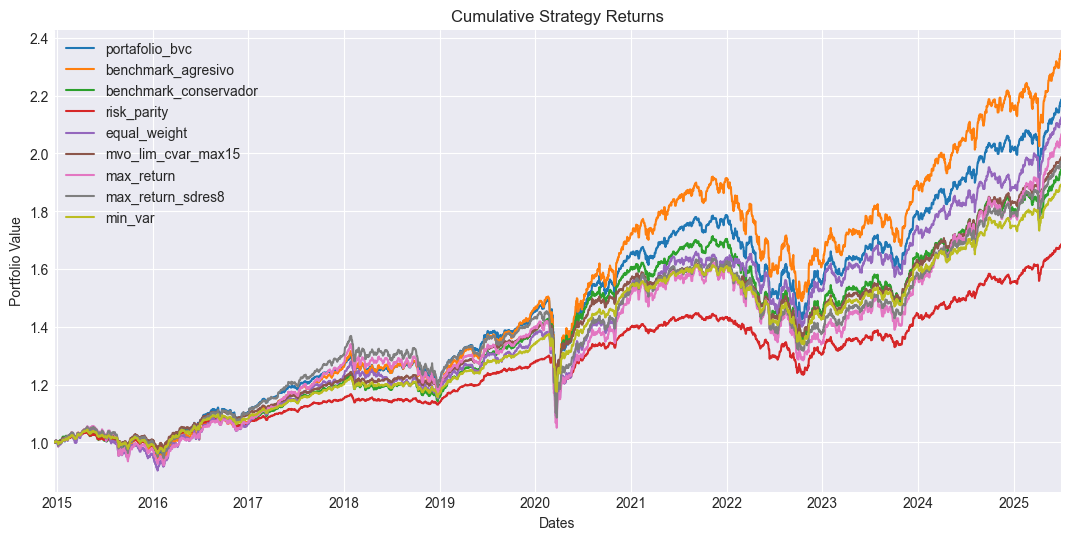

In [79]:
#Graficar los retornos de cada estrategia 
import matplotlib.pyplot as plt

returns_dict = {
    'portafolio_bvc': portafolio_bvc_results,
    'benchmark_agresivo': benchmark_agresivo_results,
    'benchmark_conservador': benchmark_conservador_results,
    'risk_parity': portfolio_rp_results,
    'equal_weight': portfolio_ew_results,
    'mvo_lim_cvar_max15': portfolio_mvo_results_lim_cvar_max15,
    'max_return': portfolio_maxreturn,
    'max_return_sdres8': portfolio_maxreturn_sdres8,
    'min_var': portfolio_min_var
}

def plot_strategy_comparison(returns_dict):
    cumulative_returns = pd.DataFrame({
        strategy: (1 + returns).cumprod() 
        for strategy, returns in returns_dict.items()
    })

    cumulative_returns.plot(figsize=(13, 6))
    plt.title('Cumulative Strategy Returns')
    plt.ylabel('Portfolio Value')
    plt.show()

plot_strategy_comparison(returns_dict)

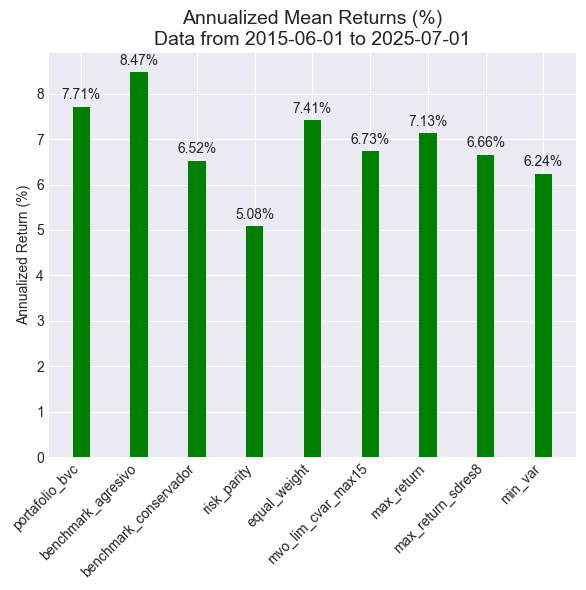

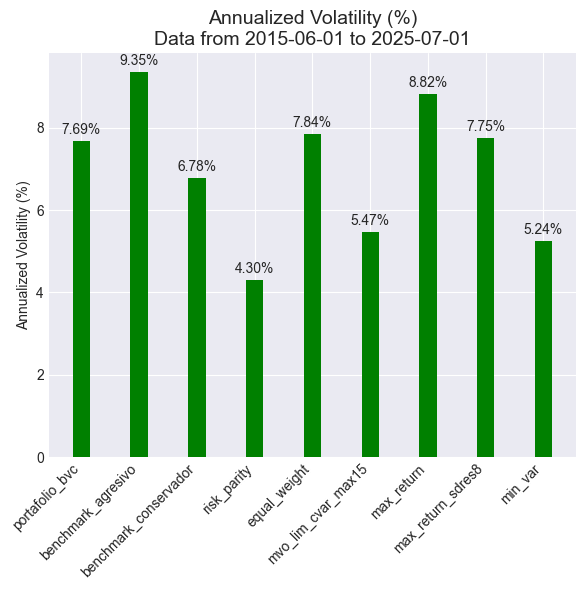

In [80]:
from plotly.subplots import make_subplots
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def plot_annualized_mean_returns(returns_dict):
    annualized_mean_returns_data = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (365 / len(returns)) - 1
        annualized_mean_returns_data[strategy] = annualized_return

    annualized_mean_returns = pd.Series(annualized_mean_returns_data)

    conditional_colors = ["green" if value > 0 else "red" for value in annualized_mean_returns]

    fig, ax = plt.subplots(figsize=(6, 6))

    bars = ax.bar(
        annualized_mean_returns.index,
        annualized_mean_returns * 100,  # Convert to percentage
        color=conditional_colors,
        width= 0.3
    );

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + np.sign(height) * 0.1,
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10
        );

    start_date = "2015-06-01"
    title_text = f"Annualized Mean Returns (%)\nData from {start_date} to {returns.index[-1].strftime('%Y-%m-%d')}"
    ax.set_title(title_text, fontsize=14);
    plt.xticks(rotation=45, ha='right');
    plt.ylabel("Annualized Return (%)");
    plt.tight_layout();
    plt.show()

def plot_annualized_volatility(returns_dict):
    annualized_volatility_data = {}
    for strategy, returns in returns_dict.items():
        annualized_volatility = returns.std() * np.sqrt(365)
        annualized_volatility_data[strategy] = annualized_volatility

    annualized_volatility = pd.Series(annualized_volatility_data)

    conditional_colors = ["green" if value > 0 else "red" for value in annualized_volatility]

    fig, ax = plt.subplots(figsize=(6, 6))

    bars = ax.bar(
        annualized_volatility.index,
        annualized_volatility * 100,  # Convert to percentage
        color=conditional_colors,
        width= 0.3
    );

    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width() / 2,
            height + np.sign(height) * 0.1,
            f'{height:.2f}%',
            ha='center', va='bottom' if height > 0 else 'top',
            fontsize=10
        );

    start_date = "2015-06-01"
    title_text = f"Annualized Volatility (%)\nData from {start_date} to {returns.index[-1].strftime('%Y-%m-%d')}"
    ax.set_title(title_text, fontsize=14);
    plt.xticks(rotation=45, ha='right');
    plt.ylabel("Annualized Volatility (%)");
    plt.tight_layout();
    plt.show()

plot_annualized_mean_returns(returns_dict)
plot_annualized_volatility(returns_dict)

In [89]:
last_weights_dictionary = {
    'portafolio_bvc': weights_portafolio_bvc.iloc[-1][weights_portafolio_bvc.iloc[-1] > 0.01],
    'benchmark_agresivo': weights_benchmark_agresivo.iloc[-1],
    'benchmark_conservador': weights_benchmark_conservador.iloc[-1],
    'risk_parity': weights_rp.iloc[-1][weights_rp.iloc[-1] > 0.01],
    'equal_weight': weights_ew.iloc[-1][weights_ew.iloc[-1] > 0.01],
    'mvo_lim_cvar_max15': weights_mvo_lim_cvar_max15.iloc[-1][weights_mvo_lim_cvar_max15.iloc[-1] > 0.01],
    'max_return': weights_maxreturn.iloc[-1][weights_maxreturn.iloc[-1] > 0.01],
    'max_return_sdres8': weights_maxreturn_sdres8.iloc[-1][weights_maxreturn_sdres8.iloc[-1] > 0.01],
    'min_var': weights_min_var.iloc[-1][weights_min_var.iloc[-1] > 0.01]
}

weights_df = pd.DataFrame(last_weights_dictionary)
weights_df 



,portafolio_bvc,benchmark_agresivo,benchmark_conservador,risk_parity,equal_weight,mvo_lim_cvar_max15,max_return,max_return_sdres8,min_var
ABS,0.016015,NaN,NaN,0.230463,0.071213,0.149623,NaN,0.149768,0.149656
Asia,0.030205,NaN,NaN,0.040182,0.071631,NaN,NaN,NaN,0.121857
Commodities,0.010038,NaN,NaN,0.052005,0.071415,0.061906,NaN,0.116459,0.069756
Emerging sov,NaN,NaN,NaN,0.074305,0.071535,NaN,NaN,NaN,0.067621
Europa bonds,0.037147,NaN,NaN,0.143804,0.071429,0.107070,NaN,NaN,0.150053
Europa equities,0.053967,NaN,NaN,0.028791,0.071102,NaN,0.149157,NaN,0.010501
Japon,0.025917,NaN,NaN,0.034221,0.070917,0.048970,NaN,0.140986,0.058615
Latam,NaN,NaN,NaN,0.027843,0.071864,NaN,0.150757,NaN,NaN
Latam corp,0.282319,NaN,NaN,0.068614,0.071479,0.150181,0.099966,0.142814,0.149393
Oro,0.025278,0.050428,0.050415,0.046917,0.071937,0.088784,0.150908,0.033980,NaN


In [90]:
def annualized_return_dict(returns_dict):
    returns_func = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (365 / len(returns)) - 1
        returns_func[strategy] = annualized_return

    return pd.Series(returns_func)

annualized_return = annualized_return_dict(returns_dict)
print(f"annualized return by strategy: \n{annualized_return}")

def annualized_volatility_dict(returns_dict):
    vol = {}
    for strategy, returns in returns_dict.items():
        annualized_volatility = returns.std() * np.sqrt(365)
        vol[strategy] = annualized_volatility

    return pd.Series(vol)

annualized_volatility = annualized_volatility_dict(returns_dict)
print(f"annualized volatility by strategy: \n{annualized_volatility}")

def annualized_sharpe_ratio(returns_dict):
    sharpe_ratios = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (365 / len(returns)) - 1
        annualized_volatility = returns.std() * np.sqrt(365)
        sharpe_ratio = annualized_return / annualized_volatility if annualized_volatility > 0 else 0
        sharpe_ratios[strategy] = sharpe_ratio

    return pd.Series(sharpe_ratios)
annualized_sharpe = annualized_sharpe_ratio(returns_dict)
print(f"annualized sharpe ratio by strategy: \n{annualized_sharpe}")

def annualized_sortino_ratio(returns_dict, target_return=0.03):
    sortino_ratios = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (365 / len(returns)) - 1
        downside_returns = returns[returns < target_return]
        downside_deviation = np.sqrt((downside_returns**2).mean()) * np.sqrt(365) if len(downside_returns) > 0 else 0
        sortino_ratio = (annualized_return - target_return) / downside_deviation if downside_deviation > 0 else 0
        sortino_ratios[strategy] = sortino_ratio

    return pd.Series(sortino_ratios)
annualized_sortino = annualized_sortino_ratio(returns_dict)
print(f"annualized sortino ratio by strategy: \n{annualized_sortino}")

def annualized_max_drawdown(returns_dict):
    max_drawdowns = {}
    for strategy, returns in returns_dict.items():
        cumulative_returns = (1 + returns).cumprod()
        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        max_drawdown = drawdown.min()
        max_drawdowns[strategy] = max_drawdown

    return pd.Series(max_drawdowns)
annualized_max_dd = annualized_max_drawdown(returns_dict)
print(f"annualized max drawdown by strategy: \n{annualized_max_dd}")

def annualized_calmar_ratio(returns_dict):
    calmar_ratios = {}
    for strategy, returns in returns_dict.items():
        annualized_return = (1 + returns).prod() ** (365 / len(returns)) - 1
        max_drawdown = annualized_max_drawdown({strategy: returns})[strategy]
        calmar_ratio = annualized_return / abs(max_drawdown) if max_drawdown < 0 else 0
        calmar_ratios[strategy] = calmar_ratio

    return pd.Series(calmar_ratios)
annualized_calmar = annualized_calmar_ratio(returns_dict)
print(f"annualized calmar ratio by strategy: \n{annualized_calmar}")

def count_non_zero_weights(last_weights_dictionary):
    non_zero_weights = {}
    for strategy, weights in last_weights_dictionary.items():
        non_zero_weights[strategy] = (weights > 0.01).sum()  # Count weights greater than 1%

    return pd.Series(non_zero_weights)
non_zero_weights_count = count_non_zero_weights(last_weights_dictionary)
print(f"Number of non-zero weights by strategy: \n{non_zero_weights_count}")

def calculate_annualized_var(returns_dict, alpha=0.05):
    annualized_var = {}
    for strategy, returns in returns_dict.items():
        var = np.percentile(returns, 100 * alpha) * np.sqrt(365)
        if var < 0:
            var = -var
        else:
            var = 0
        annualized_var[strategy] = var

    return pd.Series(annualized_var)
annualized_var = calculate_annualized_var(returns_dict)
print(f"Annualized Value at Risk (VaR) by strategy: \n{annualized_var}")

def calculate_annualized_cvar(returns_dict, alpha=0.05):
    annualized_cvar = {}
    for strategy, returns in returns_dict.items():
        var = np.percentile(returns, 100 * alpha)
        if var < 0:
            var = var
        else:
            var = 0
        cvar = (var -  (1/ (alpha * len(returns)))) * np.sum(np.maximum(var - returns, 0)) * np.sqrt(365)
        annualized_cvar[strategy] = -cvar

    return pd.Series(annualized_cvar)
annualized_cvar = calculate_annualized_cvar(returns_dict)
print(f"Annualized Conditional Value at Risk (CVaR) by strategy: \n{annualized_cvar}")

annualized return by strategy: 
portafolio_bvc           0.077054
benchmark_agresivo       0.084687
benchmark_conservador    0.065189
risk_parity              0.050837
equal_weight             0.074138
mvo_lim_cvar_max15       0.067341
max_return               0.071296
max_return_sdres8        0.066566
min_var                  0.062419
dtype: float64
annualized volatility by strategy: 
portafolio_bvc           0.076868
benchmark_agresivo       0.093468
benchmark_conservador    0.067794
risk_parity              0.042978
equal_weight             0.078428
mvo_lim_cvar_max15       0.054726
max_return               0.088234
max_return_sdres8        0.077488
min_var                  0.052405
dtype: float64
annualized sharpe ratio by strategy: 
portafolio_bvc           1.002418
benchmark_agresivo       0.906058
benchmark_conservador    0.961579
risk_parity              1.182866
equal_weight             0.945303
mvo_lim_cvar_max15       1.230509
max_return               0.808028
max_return_sdr

In [91]:
strategies_ratios = pd.DataFrame({
    'Annualized Return': annualized_return,
    'Annualized Volatility': annualized_volatility,
    'Annualized Sharpe Ratio': annualized_sharpe,
    'Annualized Sortino Ratio': annualized_sortino,
    'Annualized Max Drawdown': annualized_max_dd,
    'Annualized Calmar Ratio': annualized_calmar, 
    'Non-Zero Weights': non_zero_weights_count,
    'Annualized VaR': annualized_var,
    'Annualized CVaR': annualized_cvar
})

strategies_ratios  

,Annualized Return,Annualized Volatility,Annualized Sharpe Ratio,Annualized Sortino Ratio,Annualized Max Drawdown,Annualized Calmar Ratio,Non-Zero Weights,Annualized VaR,Annualized CVaR
portafolio_bvc,0.077054,0.076868,1.002418,0.623445,-0.223020,0.345501,12,0.106189,0.166342
benchmark_agresivo,0.084687,0.093468,0.906058,0.610004,-0.238619,0.354906,3,0.133394,0.220064
benchmark_conservador,0.065189,0.067794,0.961579,0.530276,-0.212552,0.306696,3,0.099970,0.133025
risk_parity,0.050837,0.042978,1.182866,0.483977,-0.147726,0.344128,14,0.060951,0.069076
equal_weight,0.074138,0.078428,0.945303,0.567660,-0.218238,0.339713,14,0.115901,0.158038
mvo_lim_cvar_max15,0.067341,0.054726,1.230509,0.681029,-0.157662,0.427123,9,0.079743,0.096984
max_return,0.071296,0.088234,0.808028,0.476844,-0.260076,0.274133,7,0.131891,0.210493
max_return_sdres8,0.066566,0.077488,0.859048,0.482659,-0.252753,0.263363,8,0.112233,0.167850
min_var,0.062419,0.052405,1.191098,0.617530,-0.171450,0.364067,11,0.074740,0.092549


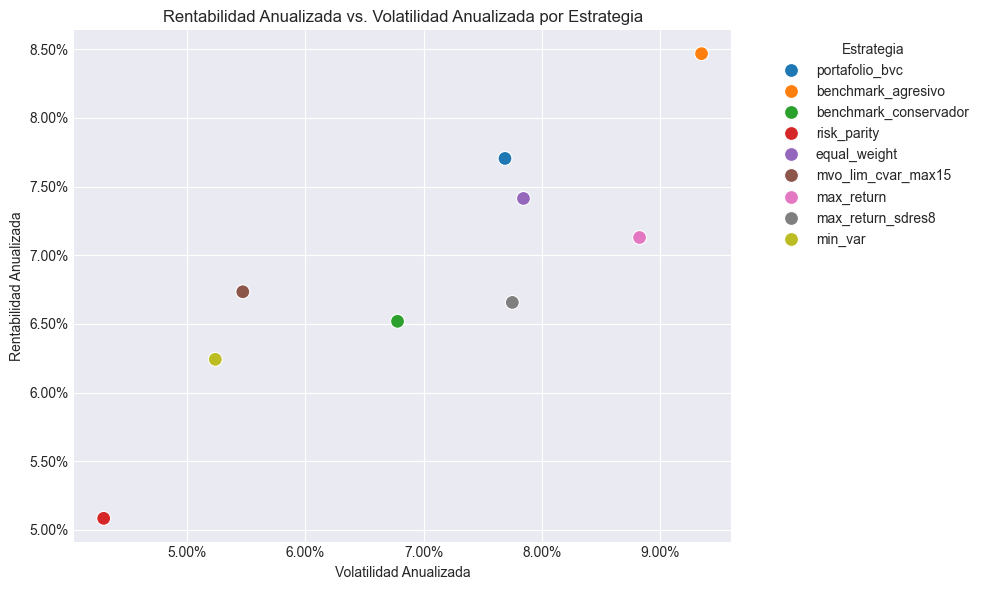

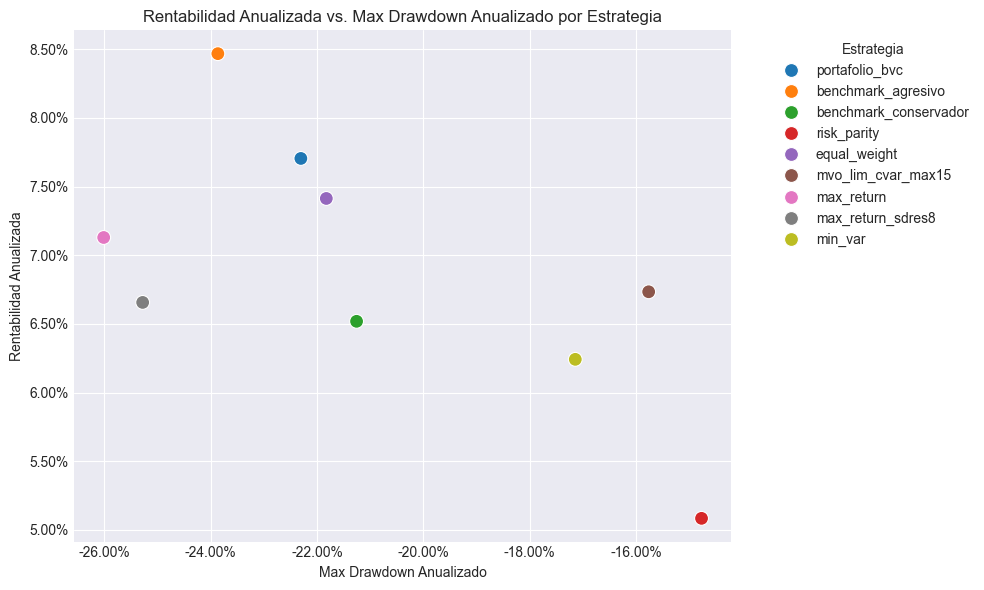

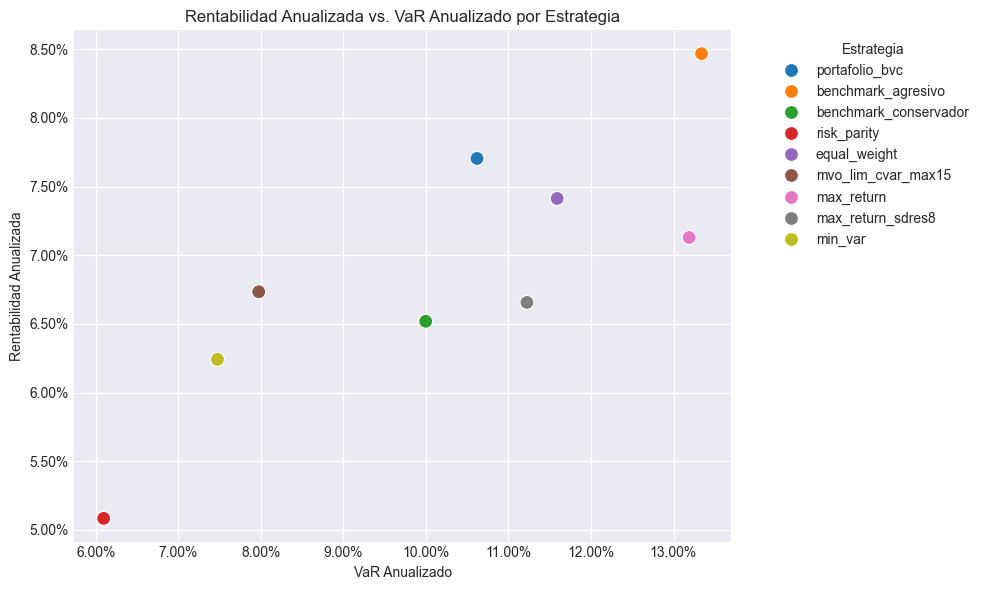

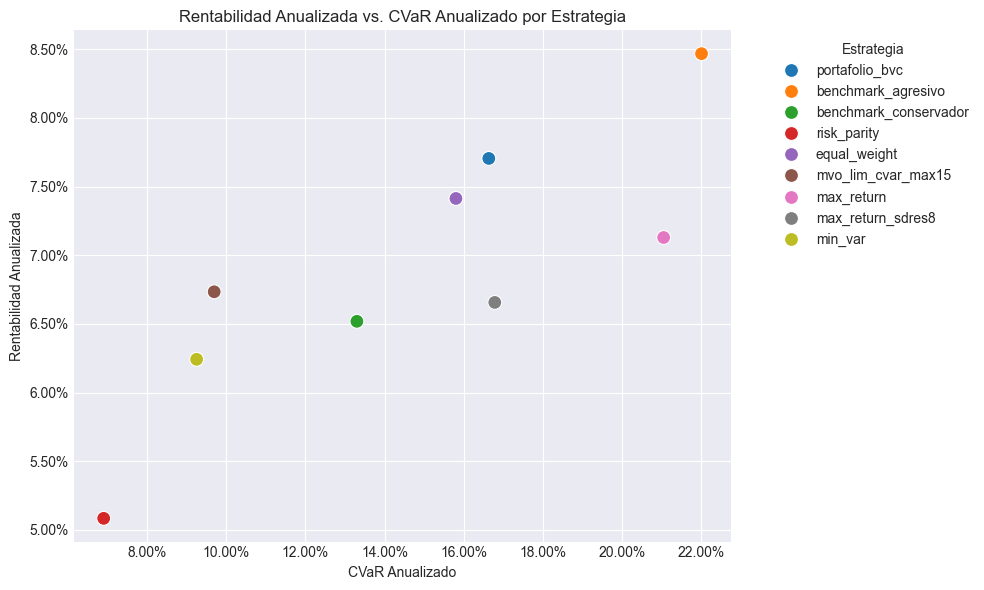

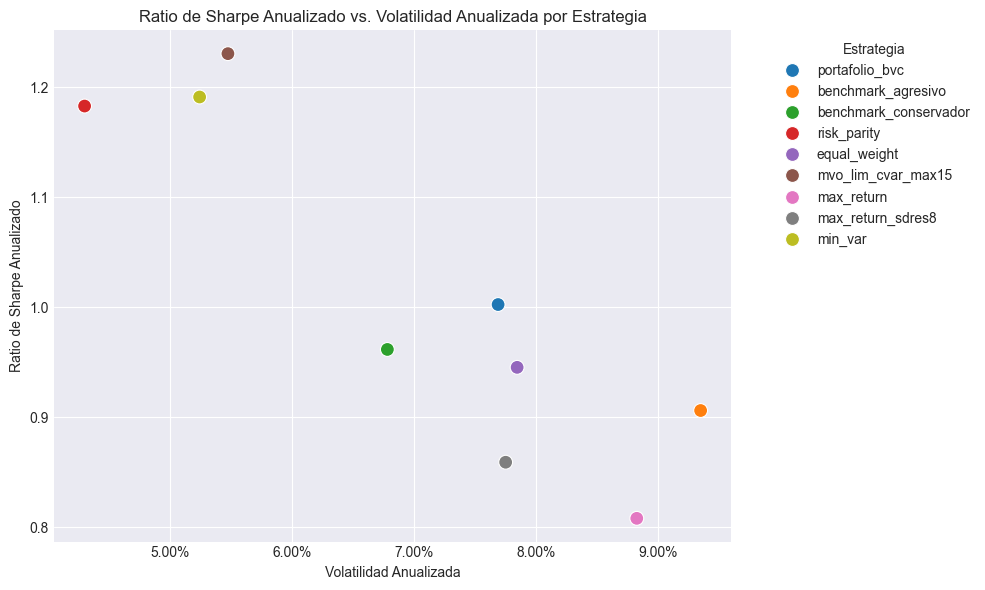

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter # Importar FuncFormatter

plt.style.use('seaborn-v0_8-darkgrid')

# Función para formatear las etiquetas de los ejes como porcentajes
# Usa '.2%' para dos decimales y el signo de porcentaje.
# Multiplicar por 100 se maneja automáticamente con el formateador de porcentaje.
def percent_formatter(x, pos):
    return f'{x:.2%}'

# 1. Rentabilidad Anualizada vs. Volatilidad Anualizada
plt.figure(figsize=(10, 6))
ax1 = sns.scatterplot(
    data=strategies_ratios,
    x='Annualized Volatility',
    y='Annualized Return',
    hue=strategies_ratios.index, # Usar nombres de estrategia para color/leyenda
    s=100, # Tamaño de los puntos
    marker='o'
)
plt.title('Rentabilidad Anualizada vs. Volatilidad Anualizada por Estrategia')
plt.xlabel('Volatilidad Anualizada')
plt.ylabel('Rentabilidad Anualizada')
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje a los ejes x e y
ax1.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax1.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.tight_layout()
plt.show()

# 2. Rentabilidad Anualizada vs. Max Drawdown Anualizado
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(
    data=strategies_ratios,
    x='Annualized Max Drawdown', # Max Drawdown suele ser negativo
    y='Annualized Return',
    hue=strategies_ratios.index,
    s=100,
    marker='o'
)
plt.title('Rentabilidad Anualizada vs. Max Drawdown Anualizado por Estrategia')
plt.xlabel('Max Drawdown Anualizado')
plt.ylabel('Rentabilidad Anualizada')
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje a los ejes x e y
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.tight_layout()
plt.show()

# 3. Rentabilidad Anualizada vs. VaR Anualizado
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(
    data=strategies_ratios,
    x='Annualized VaR', # Max Drawdown suele ser negativo
    y='Annualized Return',
    hue=strategies_ratios.index,
    s=100,
    marker='o'
)
plt.title('Rentabilidad Anualizada vs. VaR Anualizado por Estrategia')
plt.xlabel('VaR Anualizado')
plt.ylabel('Rentabilidad Anualizada')
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje a los ejes x e y
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.tight_layout()
plt.show()

# 4. Rentabilidad Anualizada vs. CVaR Anualizado. 
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(
    data=strategies_ratios,
    x='Annualized CVaR', # Max Drawdown suele ser negativo
    y='Annualized Return',
    hue=strategies_ratios.index,
    s=100,
    marker='o'
)
plt.title('Rentabilidad Anualizada vs. CVaR Anualizado por Estrategia')
plt.xlabel('CVaR Anualizado')
plt.ylabel('Rentabilidad Anualizada')
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje a los ejes x e y
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.tight_layout()
plt.show()

# 5. Ratio de Sharpe Anualizado vs. Volatilidad Anualizada (El Ratio de Sharpe no es un porcentaje)
plt.figure(figsize=(10, 6))
ax3 = sns.scatterplot(
    data=strategies_ratios,
    x='Annualized Volatility',
    y='Annualized Sharpe Ratio',
    hue=strategies_ratios.index,
    s=100,
    marker='o'
)
plt.title('Ratio de Sharpe Anualizado vs. Volatilidad Anualizada por Estrategia')
plt.xlabel('Volatilidad Anualizada')
plt.ylabel('Ratio de Sharpe Anualizado') # El Ratio de Sharpe no se expresa típicamente como porcentaje
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje SÓLO al eje x (Volatilidad Anualizada)
ax3.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
# No se aplica formateador al eje y (Ratio de Sharpe) ya que no es un porcentaje

plt.tight_layout()
plt.show()



In [93]:
bonds_dict = {
'ABS': returns_modelos['ABS'].iloc[-365*5:],
'Emerging sov': returns_modelos['Emerging sov'].iloc[-365*5:],
'Commodities': returns_modelos['Commodities'].iloc[-365*5:],
'Emerging sov': returns_modelos['Emerging sov'].iloc[-365*5:],
'Oro': returns_modelos['Oro'].iloc[-365*5:],
'US HY': returns_modelos['US HY'].iloc[-365*5:],
'US IG': returns_modelos['US IG'].iloc[-365*5:],
'Europa bonds': returns_modelos['Europa bonds'].iloc[-365*5:],
'Latam corp': returns_modelos['Latam corp'].iloc[-365*5:]
}

equities_dict = {
'Asia': returns_modelos['Asia'].iloc[-365*5:],
'Japon': returns_modelos['Japon'].iloc[-365*5:],
'UK': returns_modelos['UK'].iloc[-365*5:],
'USA': returns_modelos['USA'].iloc[-365*5:],
'World equities': returns['World equities'].iloc[-365*5:],
'Latam': returns_modelos['Latam'].iloc[-365*5:],
'Europa': returns_modelos['Europa equities'].iloc[-365*5:],
}

retornos_anualizados_equities = annualized_return_dict(equities_dict)
print(f"Annualized return for LATAM Corp: {retornos_anualizados_equities}")

volatilidad_anualizada_equities = annualized_volatility_dict(equities_dict)
print(f"Annualized volatility for LATAM Corp: {volatilidad_anualizada_equities}")

retornos_anualizados_bonds = annualized_return_dict(bonds_dict)
print(f"Annualized return for LATAM Corp: {retornos_anualizados_equities}")

volatilidad_anualizada_bonds = annualized_volatility_dict(bonds_dict)
print(f"Annualized volatility for LATAM Corp: {volatilidad_anualizada_bonds}")



Annualized return for LATAM Corp: Asia              0.069284
Japon             0.091603
UK                0.131536
USA               0.163665
World equities    0.138225
Latam             0.106870
Europa            0.122194
dtype: float64
Annualized volatility for LATAM Corp: Asia              0.165710
Japon             0.204404
UK                0.176029
USA               0.174034
World equities    0.140538
Latam             0.221867
Europa            0.183639
dtype: float64
Annualized return for LATAM Corp: Asia              0.069284
Japon             0.091603
UK                0.131536
USA               0.163665
World equities    0.138225
Latam             0.106870
Europa            0.122194
dtype: float64
Annualized volatility for LATAM Corp: ABS             0.027522
Emerging sov    0.062761
Commodities     0.156665
Oro             0.153907
US HY           0.046105
US IG           0.066586
Europa bonds    0.052999
Latam corp      0.065388
dtype: float64


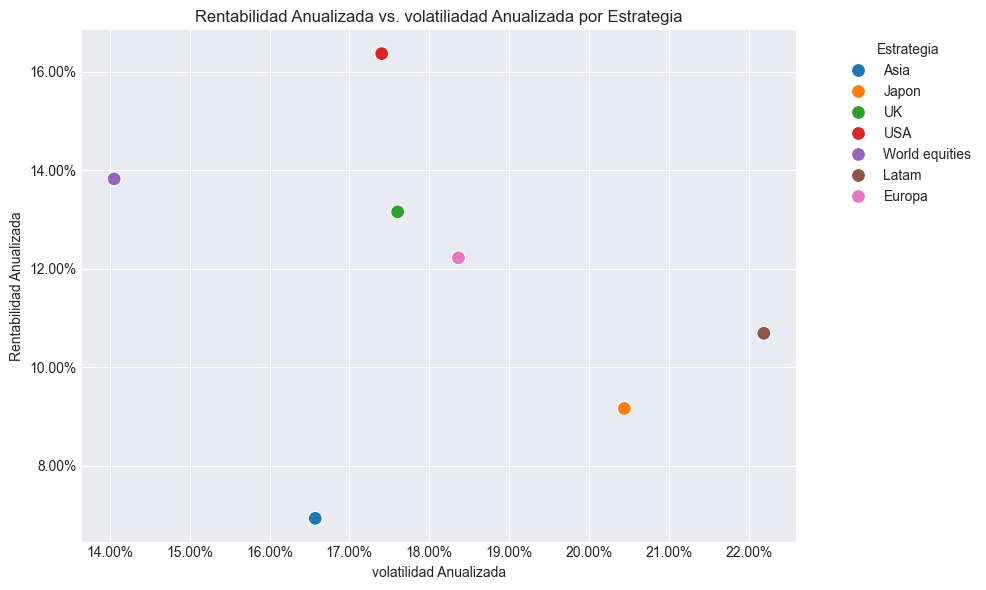

In [94]:

diccionario_eq = {
    'Annualized Return': retornos_anualizados_equities,
    'Annualized Volatility': volatilidad_anualizada_equities}

dic_eq = pd.DataFrame(diccionario_eq)

# 4. Rentabilidad Anualizada vs. CVaR Anualizado. 
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(
    data=diccionario_eq,
    x='Annualized Volatility', # Max Drawdown suele ser negativo
    y='Annualized Return',
    hue=dic_eq.index,
    s=100,
    marker='o'
)
plt.title('Rentabilidad Anualizada vs. volatiliadad Anualizada por Estrategia')
plt.xlabel('volatilidad Anualizada')
plt.ylabel('Rentabilidad Anualizada')
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje a los ejes x e y
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.tight_layout()
plt.show()

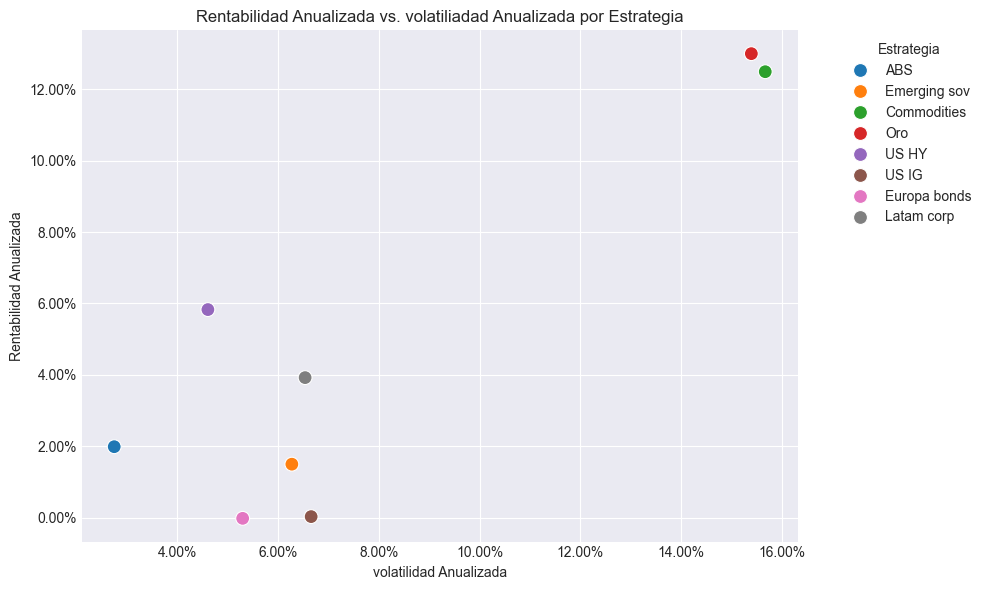

In [95]:
diccionario_bonds = {
    'Annualized Return': retornos_anualizados_bonds,
    'Annualized Volatility': volatilidad_anualizada_bonds}

dic_bonds = pd.DataFrame(diccionario_bonds)

# 4. Rentabilidad Anualizada vs. CVaR Anualizado. 
plt.figure(figsize=(10, 6))
ax2 = sns.scatterplot(
    data=diccionario_bonds,
    x='Annualized Volatility', # Max Drawdown suele ser negativo
    y='Annualized Return',
    hue=dic_bonds.index,
    s=100,
    marker='o'
)
plt.title('Rentabilidad Anualizada vs. volatiliadad Anualizada por Estrategia')
plt.xlabel('volatilidad Anualizada')
plt.ylabel('Rentabilidad Anualizada')
plt.legend(title='Estrategia', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Aplicar el formateador de porcentaje a los ejes x e y
ax2.xaxis.set_major_formatter(FuncFormatter(percent_formatter))
ax2.yaxis.set_major_formatter(FuncFormatter(percent_formatter))

plt.tight_layout()
plt.show()

In [96]:
def annualized_max_drawdown_with_dates(returns_dict):
    results = {}
    for strategy, returns in returns_dict.items():
        if returns.empty:
            results[strategy] = {'Max Drawdown': np.nan, 'Peak Date': pd.NaT, 'Trough Date': pd.NaT}
            continue

        cumulative_returns = (1 + returns).cumprod()
        peak_series = cumulative_returns.cummax() # Guarda la Serie de picos históricos
        
        # Calcula el drawdown para cada punto en el tiempo
        drawdown = (cumulative_returns - peak_series) / peak_series
        
        # Encuentra el valor mínimo del drawdown (el Max Drawdown)
        max_drawdown_value = drawdown.min()
        
        # Encuentra la fecha del mínimo (trough)
        # Usamos idxmin() para obtener el índice de la primera ocurrencia del valor mínimo
        trough_date = drawdown.idxmin()
        
        # Para encontrar la fecha del peak, necesitamos encontrar el peak_series
        # que corresponde al inicio de la caída que llevó al trough_date.
        # Es el máximo valor ANTES o IGUAL a la fecha del mínimo.
        # Buscamos el peak_series en el mismo índice que el trough, pero el peak
        # real puede haber ocurrido antes.
        
        # Una forma robusta es buscar el peak_series entre el inicio de los retornos
        # y la fecha del mínimo (inclusive).
        # El 'peak' para un drawdown específico es el máximo valor ANTES o EN el trough_date
        # donde el valor es el máximo histórico.
        
        # Mejor manera: Iterar para encontrar el pico exacto antes del mínimo
        # El peak es el máximo valor alcanzado *hasta* el trough_date.
        # Buscamos el índice donde cumulative_returns es igual al peak_series en trough_date.
        # Es decir, cumulative_returns.loc[:trough_date].max()
        
        peak_at_trough = peak_series.loc[trough_date] # El peak al momento del trough
        
        # Encuentra la primera fecha donde cumulative_returns alcanzó ese 'peak_at_trough'
        # antes o en la fecha del mínimo (trough_date).
        # Es importante que sea el peak *antes* o *al inicio* de la caída.
        
        # Filtra los puntos que son iguales al peak_at_trough y ocurren antes o en trough_date
        potential_peak_dates = cumulative_returns[cumulative_returns == peak_at_trough].index
        
        # De esos, elige el más reciente que sea <= trough_date
        peak_date = potential_peak_dates[potential_peak_dates <= trough_date].max()
        
        results[strategy] = {
            'Max Drawdown': max_drawdown_value,
            'Peak Date': peak_date,
            'Trough Date': trough_date
        }

    # Devuelve un DataFrame para mejor visualización
    return pd.DataFrame(results).T # .T transpone para que las estrategias sean el índice

# Llama a la nueva función
max_dd_details = annualized_max_drawdown_with_dates(returns_dict)
print("Detalles del Max Drawdown por estrategia:")
print(max_dd_details)

# Si solo necesitas el valor del max drawdown como antes:
annualized_max_dd = max_dd_details['Max Drawdown']
print(f"\nMax Drawdown Anualizado por estrategia (solo valor): \n{annualized_max_dd}")

Detalles del Max Drawdown por estrategia:
                      Max Drawdown            Peak Date          Trough Date
portafolio_bvc            -0.22302  2020-02-19 00:00:00  2020-03-23 00:00:00
benchmark_agresivo       -0.238619  2020-02-19 00:00:00  2020-03-23 00:00:00
benchmark_conservador    -0.212552  2021-11-09 00:00:00  2022-10-14 00:00:00
risk_parity              -0.147726  2021-09-06 00:00:00  2022-10-20 00:00:00
equal_weight             -0.218238  2020-01-19 00:00:00  2020-03-23 00:00:00
mvo_lim_cvar_max15       -0.157662  2021-11-09 00:00:00  2022-10-20 00:00:00
max_return               -0.260076  2020-02-12 00:00:00  2020-03-23 00:00:00
max_return_sdres8        -0.252753  2020-02-12 00:00:00  2020-03-23 00:00:00
min_var                   -0.17145  2021-09-06 00:00:00  2022-10-20 00:00:00

Max Drawdown Anualizado por estrategia (solo valor): 
portafolio_bvc           -0.22302
benchmark_agresivo      -0.238619
benchmark_conservador   -0.212552
risk_parity             -0.1477